# Markov chain Monte Carlo: Metropolis Hastings

In [1]:
import hypothesis
import matplotlib.pyplot as plt

from hypothesis.inference.mcmc import MetropolisHastings

In [22]:
import torch
class Uniform(torch.distributions.uniform.Uniform):

    def __init__(self, lower, upper):
        super(Uniform, self).__init__(lower, upper)

    def log_prob(self, sample):
        return super(Uniform, self).log_prob(sample).mean()


def Prior():
    lower = -3 * torch.ones(5).float()
    upper = 3 * torch.ones(5).float()

    return Uniform(lower, upper)

prior = Prior()

The Metropolis-Hastings sampler needs a proposal (or transition) mechanism to propose states $\theta'$. This can be done using a *transition distribution*. As the target space is univariate, we simply import a `NormalTransition` to generate proposals.

In [26]:
from hypothesis.inference.transition_distribution import MultivariateNormal

transition = MultivariateNormal(torch.eye(5))

In [27]:
transition.sigma

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

The likelihood of the generating process is normal. The log likelihood function in Hypothesis' MCMC samplers accept a parameter $\theta$ (tensor) and a tensor of observations.

In [63]:
from hypothesis.benchmark.tractable import Truth


from torch.distributions.multivariate_normal import MultivariateNormal as Normal

def log_likelihood(theta, x):
    with torch.no_grad():
        input = theta.reshape(-1)
        mean = torch.tensor([input[0], input[1]])
        scale = 1.0
        s_1 = input[2] ** 2
        s_2 = input[3] ** 2
        rho = input[4].tanh()
        covariance = torch.tensor([
            [scale * s_1 ** 2, scale * rho * s_1 * s_2],
            [scale * rho * s_1 * s_2, scale * s_2 ** 2]])
        normal = Normal(mean, covariance)
        m = x.view(-1, 2)
        log_likelihood = normal.log_prob(m).sum()

    return log_likelihood

We draw an observation from the forward model using an assumed truth:

In [64]:
from hypothesis.benchmark.tractable import Simulator
truth = Truth().view(1,-1)
simulator = Simulator()
observations = simulator(truth).view(-1,8)

In [65]:
observations

tensor([[ 0.7565, -2.4123, -0.3019, -3.5528,  1.4937, -3.2792,  1.8211, -3.9903]])

We setup the Metropolis Hastings sampler using the components specified above:

In [66]:
sampler = MetropolisHastings(prior, log_likelihood, transition)

First, we need to let the Markov chain converge to its stationary distribution. This can be achieved using a *burnin chain*.

ValueError: not enough values to unpack (expected 3, got 2)

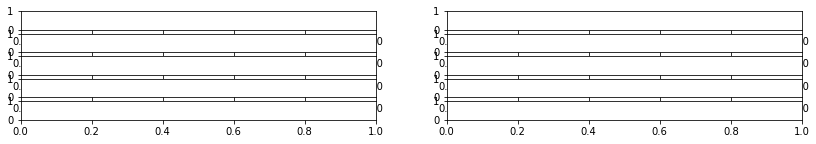

In [87]:
from hypothesis.visualization.mcmc import plot_trace


theta = prior.sample().view(-1,1)
burnin_chain = sampler.sample(observations, theta, num_samples=20000)

#figure = plot_trace(burnin_chain)
#plt.show()

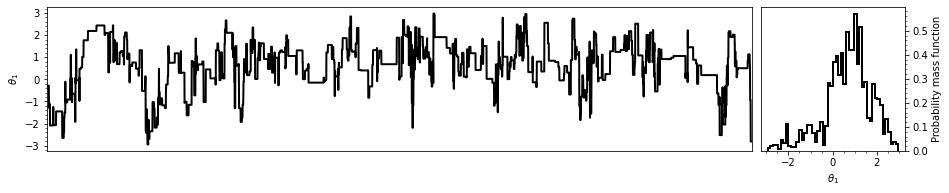

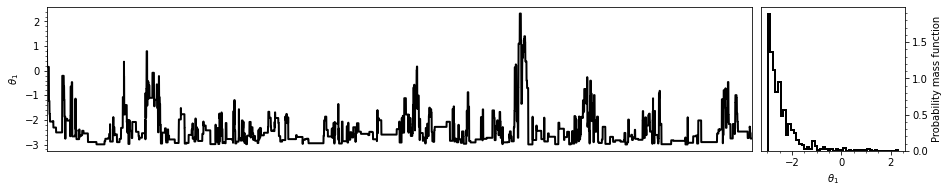

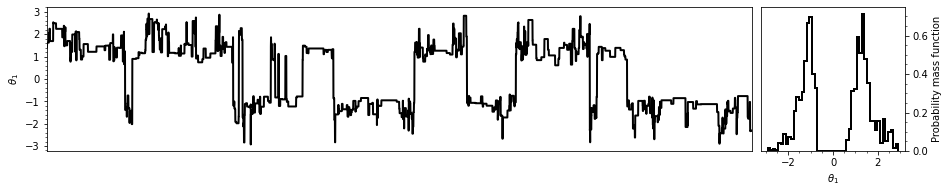

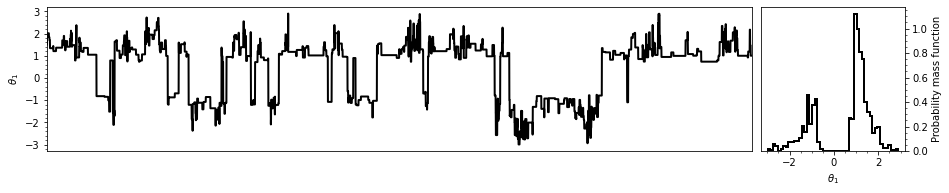

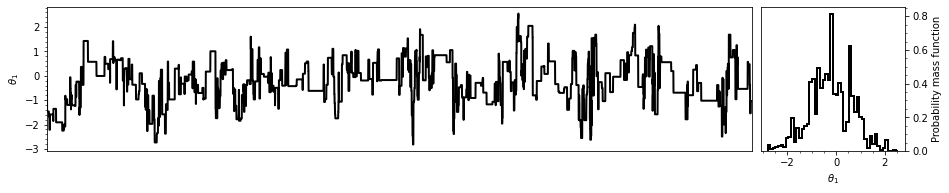

In [88]:
from hypothesis.visualization.util import make_square

def plot_trace(chain, theta_index=1):
    nrows = 1
    figure, rows = plt.subplots(nrows, 2, sharey=False, sharex=False, figsize=(2 * 7, 2))
    num_samples = chain.size
    def display(ax_trace, ax_density):
        # Trace
        ax_trace.minorticks_on()
        ax_trace.plot(range(num_samples), chain, color="black", lw=2)
        ax_trace.set_xlim([0, num_samples])
        ax_trace.set_xticks([])
        ax_trace.set_ylabel(r"$\theta_" + str(theta_index) + "$")
        limits = ax_trace.get_ylim()
        # Density
        ax_density.minorticks_on()
        ax_density.hist(chain, bins=50, lw=2, color="black", histtype="step", density=True)
        ax_density.yaxis.tick_right()
        ax_density.yaxis.set_label_position("right")
        ax_density.set_ylabel("Probability mass function")
        ax_density.set_xlabel(r"$\theta_" + str(theta_index) + "$")
        ax_density.set_xlim(limits)
        # Aspects
        make_square(ax_density)
        ax_trace.set_aspect("auto")
        ax_trace.set_position([0, 0, .7, 1])
        ax_density.set_position([.28, 0, 1, 1])
    if nrows > 1:
        for index, (ax_trace, ax_density) in enumerate(rows):
            display(ax_trace, ax_density, theta_index=index)
    else:
        ax_trace, ax_density = rows
        display(ax_trace, ax_density)

    return figure

for ind, burnin_chain_individual in enumerate(np.transpose(burnin_chain.samples.numpy())):
    figure = plot_trace(burnin_chain_individual)
    plt.show()

Finally, after the burnin chain converged to its stationary distribution, we let the MetropolisHastings draw samples from the posterior.

In [89]:
theta = burnin_chain[-1]
print(theta)

tensor([-2.8108, -2.7582, -2.3071,  1.0063, -1.0369])


In [94]:
import time

theta = burnin_chain[-1]
print(theta)

start = time.monotonic()
chain = sampler.sample(observations, theta, num_samples=1000000)
end = time.monotonic()

print('Time in seconds : ', end-start)

tensor([-2.8108, -2.7582, -2.3071,  1.0063, -1.0369])
Time in seconds :  540.2736043689947


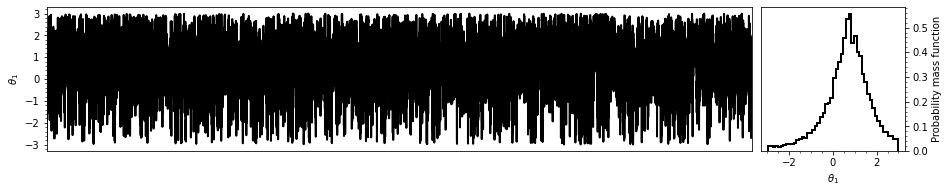

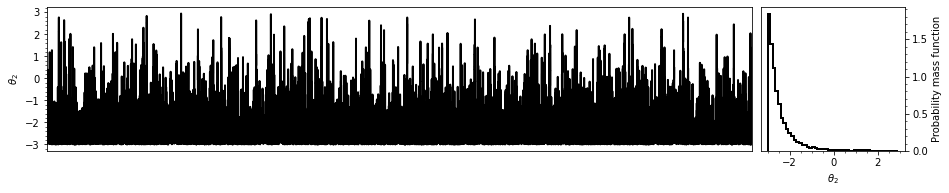

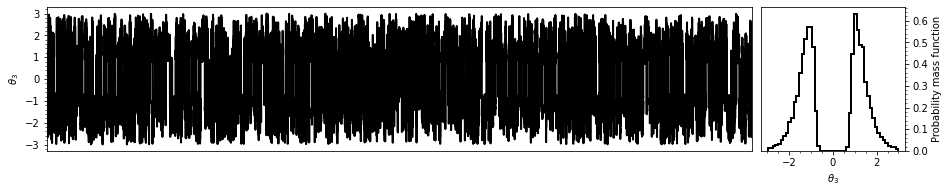

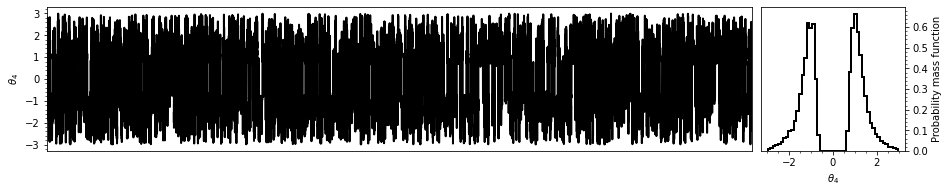

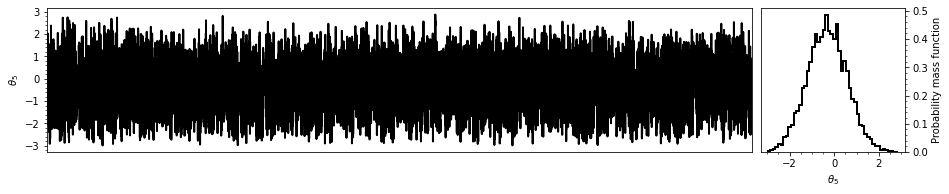

In [95]:
for ind, chain_individual in enumerate(np.transpose(chain.samples.numpy())):
    figure = plot_trace(chain_individual, theta_index=ind+1)
    plt.show()

In [119]:
np.save('observations.npy', observations.numpy())

In [120]:
np.save('mcmc_samples_gt.npy', chain.samples.numpy())